In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt

import tensorflow as tf

print (tf.__version__)

2.0.0-beta0


In [4]:
import tensorflow_hub as hub

from tensorflow.keras import layers

## Use transfer learning model

In [5]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [6]:
# Use hub.KerasLayer to load pretrained model
# Declare input shape
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

65536/61306 [================================] - 0s 1us/step


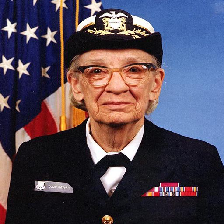

In [7]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [8]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [39]:
# 1001 classes, add new axis to make true input format
result = classifier.predict(grace_hopper[np.newaxis, :])
result.shape

(1, 1001)

In [13]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

In [14]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


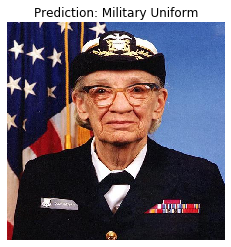

In [15]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Retrain model

In [16]:
# Set up new dataset (5 classes of flowers)
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228818944/228813984 [==============================] - 22s 0us/step


In [17]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [38]:
# image_data break to 32 element batches
for image in image_data:
    for item in image:
        print (item.shape)
        break
    break

(32, 224, 224, 3)


In [19]:
for image_batch, label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [20]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [21]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['umbrella', 'daisy', 'fig', 'coral fungus', 'stretcher', 'daisy',
       'daisy', 'swing', 'daisy', 'daisy', 'cardoon', 'daisy', 'admiral',
       'daisy', 'hip', 'strawberry', 'quill', 'wool', 'daisy',
       'picket fence', 'cardoon', 'rapeseed', 'daisy', 'daisy', 'bee',
       'hip', 'daisy', 'daisy', 'orange', 'umbrella', 'stinkhorn', 'bee'],
      dtype='<U30')

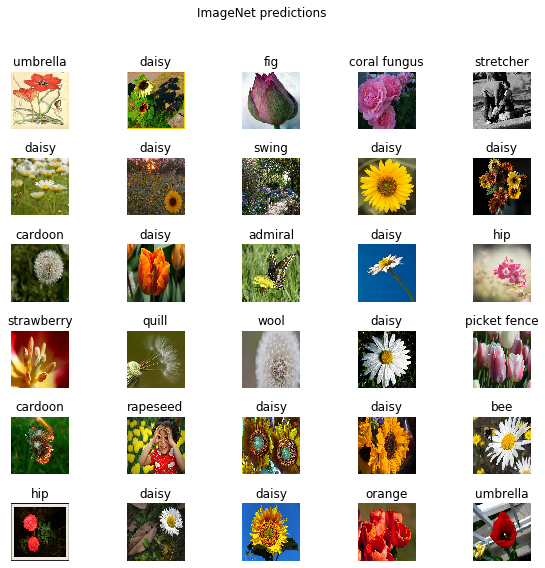

In [22]:
# Before retrain, predict can't true
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
    _ = plt.suptitle("ImageNet predictions")

In [23]:
# Load pretrained model to feature_extractor_layer
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

# Feature_extractor_layer returns a 1280-length vector for each image:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [24]:
# Freeze the variables in the feature extractor layer, so that the training only modifies 
# the new classifier layer.
feature_extractor_layer.trainable = False

In [25]:
# New model include feature_extractor_layer && Dense layer
# Dense layer to classifier 5 classes flowers
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [26]:
# Check output model
predictions = model(image_batch)
predictions.shape

TensorShape([32, 5])

In [27]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [28]:
# To keep this example short train just 2 epochs. To visualize the training progress, 
# use a custom callback to log the loss and accuracy of each batch individually, instead of the epoch average.
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

In [29]:
# Retrain model
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

Epoch 1/2
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


115/115 [==============================] - 127s 1s/step - loss: 0.6779 - acc: 0.7812
Epoch 2/2
115/115 [==============================] - 121s 1s/step - loss: 0.3382 - acc: 0.8125


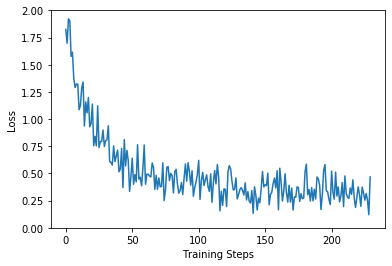

In [30]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

### Check the predictions

In [40]:
for label in image_data.class_indices.items():
    print (label)

('daisy', 0)
('dandelion', 1)
('roses', 2)
('sunflowers', 3)
('tulips', 4)


In [41]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [42]:
image_batch.shape

(32, 224, 224, 3)

In [43]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [44]:
label_id = np.argmax(label_batch, axis=-1)

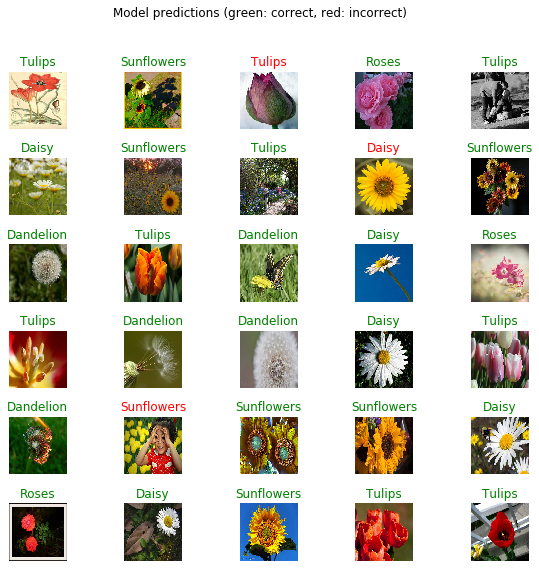

In [45]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(predicted_label_batch[n].title(), color=color)
    plt.axis('off')
    _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [46]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1577701194/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1577701194/assets


'/tmp/saved_models/1577701194'

In [47]:
reloaded = tf.keras.models.load_model(export_path)

result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [48]:
abs(reloaded_result_batch - result_batch).max()

0.0